
#  Tech Challenge – Fase 2 (Projeto 2)
## **VRP com Algoritmo Genético + Mapas + LLM (Colab-ready)**

Este projeto um **problema de rotas médicas** (VRP) usando **Algoritmo Genético (AG)**, desenha as rotas no **mapa** e cria um **gancho para LLM** gerar instruções/relatórios.

**O que você vai ver:**
1. Setup (instalação de libs);
2. Dados de exemplo (depósito + clientes);
3. TSP com AG (rota única) – base;
4. VRP com penalidades (capacidade, autonomia, prioridade, múltiplos veículos);
5. Visualização em mapa (folium);
6. Baseline (vizinho mais próximo) para comparar;
7. Experimentos A/B/C do AG;
8. Placeholder de LLM (onde plugar a API);
9. Export de resultados (CSV/PNG).

> **Lembrete**: Isso é **apoio à decisão**. Não é diagnóstico e não substitui ninguém.


In [1]:

try:
    import folium
except:
    !pip -q install folium

import math, random, os, json
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)



### 1 - O que são os dados?
- **Depósito (Hospital)**: ponto de partida e chegada.
- **Clientes**: lugares onde vamos entregar remédios/insumos.
- Cada cliente tem:
  - **demanda** (quanto pesa);
  - **prioridade** (0 = normal, 1 = crítica).
- Temos **vários veículos**, cada um com **capacidade** e **autonomia**.


In [2]:

def jitter_points(base_lat, base_lon, meters_lat=8000, meters_lon=8000, n=20):
    pts = []
    for _ in range(n):
        dlat = (np.random.rand()-0.5)*meters_lat/111111  # metro -> grau aprox
        dlon = (np.random.rand()-0.5)*meters_lon/(111111*math.cos(math.radians(base_lat)))
        pts.append((base_lat + dlat, base_lon + dlon))
    return pts

# Depósito (ex.: São Paulo - Sé)
depot = (-23.5505, -46.6333)

# Gera 20 clientes ao redor
customers = jitter_points(depot[0], depot[1], n=20)

# Demandas (peso) e prioridade (0=normal, 1=crítica)
demands = np.random.randint(1, 5, size=len(customers))   # 1..4
priority = np.random.choice([0,1], size=len(customers), p=[0.7,0.3])

# Frota/Restrições
NUM_VEHICLES   = 3
VEHICLE_CAP    = 18   # capacidade máxima por veículo (soma das demandas)
VEHICLE_RANGE  = 30.0 # autonomia máxima por rota (km)

# Distância Haversine (km)
from math import radians, sin, cos, asin, sqrt
def haversine_km(a, b):
    lat1, lon1 = a; lat2, lon2 = b
    dlat = radians(lat2-lat1); dlon = radians(lon2-lon1)
    R = 6371
    h = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*asin(sqrt(h))

# Matriz de distância entre todos os pontos (0 = depot, 1..n = clientes)
points = [depot] + customers
N = len(points)
D = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        D[i, j] = 0 if i==j else haversine_km(points[i], points[j])

print(f"Clientes: {len(customers)} | Veículos: {NUM_VEHICLES} | Capacidade: {VEHICLE_CAP} | Autonomia: {VEHICLE_RANGE} km")


Clientes: 20 | Veículos: 3 | Capacidade: 18 | Autonomia: 30.0 km



## 2 - TSP com Algoritmo Genético (base)

O **Algoritmo genético** faz:
- **seleção**: escolhe as melhores rotas (as mais curtas);
- **crossover**: mistura rotas de dois pais;
- **mutação**: troca dois individuos de lugar às vezes;
- **elitismo**: guarda os melhores.

**Fitness**: distância total (menor = melhor).


Best TSP distance (km): 40.64


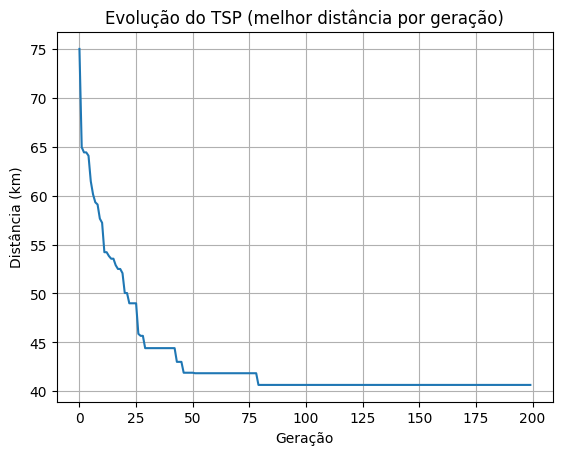

In [3]:

# TSP com AG

NUM_CUSTOMERS = len(customers)
POP           = 60
GENERATIONS   = 200
MUTATION_P    = 0.15
TOURNEY_K     = 3
ELITE         = 6

def route_length(order):
    total = D[0, order[0]]
    for i in range(len(order)-1):
        total += D[order[i], order[i+1]]
    total += D[order[-1], 0]
    return total

def init_pop():
    base = list(range(1, NUM_CUSTOMERS+1))
    pop = []
    for _ in range(POP):
        random.shuffle(base)
        pop.append(base.copy())
    return pop

def tournament(pop, fitnesses, k=TOURNEY_K):
    cand = random.sample(range(len(pop)), k)
    best = min(cand, key=lambda i: fitnesses[i])
    return pop[best]

def ordered_crossover(p1, p2):
    a, b = sorted(random.sample(range(len(p1)), 2))
    child = [None]*len(p1)
    child[a:b+1] = p1[a:b+1]
    fill = [g for g in p2 if g not in child]
    j=0
    for i in range(len(child)):
        if child[i] is None:
            child[i] = fill[j]; j+=1
    return child

def mutate_swap(ind, p=MUTATION_P):
    if random.random() < p:
        i, j = random.sample(range(len(ind)), 2)
        ind[i], ind[j] = ind[j], ind[i]

def evolve_tsp():
    pop = init_pop()
    best = None; best_f = float('inf')
    history = []
    for g in range(GENERATIONS):
        fitnesses = [route_length(ind) for ind in pop]
        gen_best_i = min(range(len(pop)), key=lambda i: fitnesses[i])
        if fitnesses[gen_best_i] < best_f:
            best_f = fitnesses[gen_best_i]; best = pop[gen_best_i][:]
        history.append(best_f)

        elite_idx = sorted(range(len(pop)), key=lambda i: fitnesses[i])[:ELITE]
        new_pop = [pop[i][:] for i in elite_idx]

        while len(new_pop) < POP:
            p1 = tournament(pop, fitnesses)
            p2 = tournament(pop, fitnesses)
            child = ordered_crossover(p1, p2)
            mutate_swap(child)
            new_pop.append(child)
        pop = new_pop
    return best, best_f, history

best_tsp, best_tsp_dist, curve_tsp = evolve_tsp()
print("Best TSP distance (km):", round(best_tsp_dist, 2))

# Curva de evolução
plt.figure()
plt.plot(curve_tsp)
plt.title("Evolução do TSP (melhor distância por geração)")
plt.xlabel("Geração")
plt.ylabel("Distância (km)")
plt.grid(True)
plt.show()



## 3 - VRP (múltiplos veículos) com **penalidades**  
A função **split** faz cortes respeitando:
- **capacidade** do veículo;
- **autonomia** da rota;
- **prioridade**: urgentes mais cedo = melhor (menos penalidade);
- **número máximo de veículos**.

Se **quebrar regra**, ganha (penalidade) e o **fitness** fica pior.


Melhor custo VRP (km + penalidades): 73.01


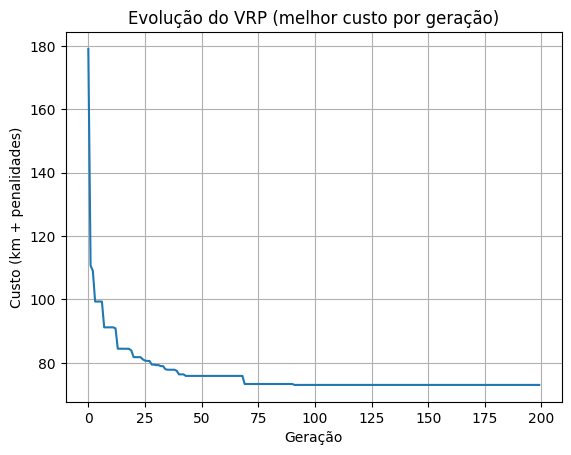

In [4]:

# VRP com penalidades

def split_into_routes(order):
    routes = []
    cur = []
    cur_demand = 0
    cur_dist = 0.0
    last = 0  # começamos no depósito (índice 0 na matriz D)

    for c in order:
        d = demands[c-1]
        # custo extra se incluir este cliente na rota atual
        extra_dist = D[last, c] + D[c, 0] - D[last, 0]
        if (cur_demand + d <= VEHICLE_CAP) and (cur_dist + extra_dist <= VEHICLE_RANGE):
            cur.append(c)
            cur_demand += d
            cur_dist += D[last, c]
            last = c
        else:
            # fecha a rota atual
            cur_dist += D[last, 0]
            routes.append((cur[:], cur_demand, cur_dist))
            # inicia nova
            cur = [c]; cur_demand = d
            last = c
            cur_dist = D[0, c]
    # fecha a última rota
    if cur:
        cur_dist += D[last, 0]
    routes.append((cur[:], cur_demand, cur_dist))
    return routes  # lista de (clientes, demanda_total, dist_total)

def vrp_fitness(order):
    routes = split_into_routes(order)
    penalty = 0.0
    # penaliza excesso de veículos
    if len(routes) > NUM_VEHICLES:
        penalty += 1000.0 * (len(routes) - NUM_VEHICLES)
    total_dist = 0.0
    for idx, (r, dem, dist) in enumerate(routes):
        total_dist += dist
        if dem > VEHICLE_CAP:
            penalty += 500.0 * (dem - VEHICLE_CAP)
        if dist > VEHICLE_RANGE:
            penalty += 500.0 * (dist - VEHICLE_RANGE)
        # prioridade: quanto mais tarde o urgente aparece, mais penaliza
        for pos, c in enumerate(r):
            if priority[c-1] == 1:
                penalty += 2.0 * pos
    return total_dist + penalty

def evolve_vrp(pop_size=60, generations=200, mut_p=0.15, tournament_k=3, elite=6):
    global POP, GENERATIONS, MUTATION_P, TOURNEY_K, ELITE
    POP, GENERATIONS, MUTATION_P, TOURNEY_K, ELITE = pop_size, generations, mut_p, tournament_k, elite

    pop = init_pop()
    best = None; best_f = float('inf')
    history = []
    for g in range(GENERATIONS):
        fitnesses = [vrp_fitness(ind) for ind in pop]
        gen_best_i = min(range(len(pop)), key=lambda i: fitnesses[i])
        if fitnesses[gen_best_i] < best_f:
            best_f = fitnesses[gen_best_i]; best = pop[gen_best_i][:]
        history.append(best_f)

        elite_idx = sorted(range(len(pop)), key=lambda i: fitnesses[i])[:ELITE]
        new_pop = [pop[i][:] for i in elite_idx]
        while len(new_pop) < POP:
            p1 = tournament(pop, fitnesses)
            p2 = tournament(pop, fitnesses)
            child = ordered_crossover(p1, p2)
            mutate_swap(child)
            new_pop.append(child)
        pop = new_pop
    return best, best_f, history

best_vrp, best_vrp_cost, curve_vrp = evolve_vrp()
print("Melhor custo VRP (km + penalidades):", round(best_vrp_cost, 2))

plt.figure()
plt.plot(curve_vrp)
plt.title("Evolução do VRP (melhor custo por geração)")
plt.xlabel("Geração")
plt.ylabel("Custo (km + penalidades)")
plt.grid(True)
plt.show()


Melhor custo final: 70.22
Não consegui salvar o GIF agora: [Errno 2] No such file or directory: 'reports'


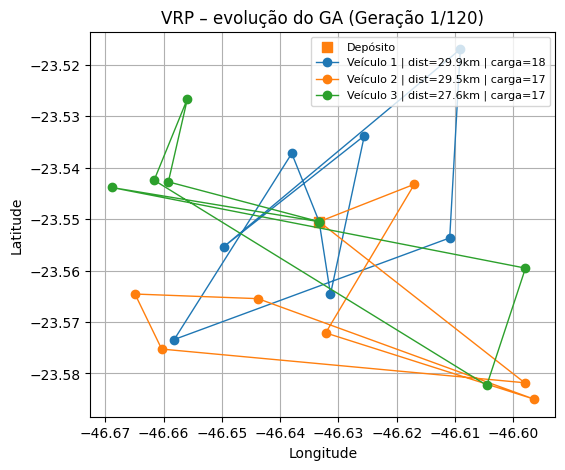

In [5]:

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def evolve_vrp_with_history(pop_size=60, generations=120, mut_p=0.15, tournament_k=3, elite=6):
    """
    Igual ao evolve_vrp, mas guarda:
      - best_cost_history: melhor custo por geração
      - best_route_history: melhor cromossomo (ordem dos clientes) por geração
    """
    # usamos as mesmas funções auxiliares já definidas no notebook
    pop = init_pop()
    best = None; best_f = float('inf')

    best_cost_history = []
    best_route_history = []

    for g in range(generations):
        fitnesses = [vrp_fitness(ind) for ind in pop]
        gen_best_i = min(range(len(pop)), key=lambda i: fitnesses[i])
        gen_best_cost = fitnesses[gen_best_i]
        gen_best_route = pop[gen_best_i][:]

        # atualiza melhor global
        if gen_best_cost < best_f:
            best_f = gen_best_cost
            best = gen_best_route[:]

        # guarda históricos (melhor global até esta geração)
        best_cost_history.append(best_f)
        best_route_history.append(best[:])

        # elitismo + reprodução
        elite_idx = sorted(range(len(pop)), key=lambda i: fitnesses[i])[:elite]
        new_pop = [pop[i][:] for i in elite_idx]
        while len(new_pop) < pop_size:
            p1 = tournament(pop, fitnesses, k=tournament_k)
            p2 = tournament(pop, fitnesses, k=tournament_k)
            child = ordered_crossover(p1, p2)
            mutate_swap(child, p=mut_p)
            new_pop.append(child)
        pop = new_pop

    return best, best_f, best_cost_history, best_route_history

# Rodar o algoritmo genético com histórico
best_route_hist_conf = dict(pop_size=60, generations=120, mut_p=0.15, tournament_k=3, elite=6)
best_final, best_final_cost, cost_hist, route_hist = evolve_vrp_with_history(**best_route_hist_conf)
print(f"Melhor custo final: {best_final_cost:.2f}")

# Funções auxiliares de desenho
def _order_to_coords(order):
    """Converte ordem de clientes em coordenadas (lat, lon), incluindo ida/volta ao depósito."""
    coords = [points[0]] + [points[c] for c in order] + [points[0]]
    return coords

def draw_route(order, ax, title_extra=""):
    """Desenha uma rota única (TSP) no plano. Útil como base visual."""
    ax.clear()
    coords = _order_to_coords(order)
    xs = [lon for (lat, lon) in coords]
    ys = [lat for (lat, lon) in coords]
    ax.plot(xs, ys, marker='o', linewidth=1)
    # destaca depósito
    ax.plot(points[0][1], points[0][0], marker='s', markersize=8)
    ax.set_title(f"Evolução do GA {title_extra}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

def draw_routes_vrp(order, ax, title_extra=""):
    """
    Desenha as SUB-ROTAS (VRP) cortando a ordem grande em rotas de veículos.
    Cada sub-rota recebe uma cor diferente.
    """
    ax.clear()
    routes = split_into_routes(order)
    colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]

    # pontos dos clientes
    xs_all = [p[1] for p in points]
    ys_all = [p[0] for p in points]
    ax.scatter(xs_all[1:], ys_all[1:], s=15, alpha=0.7)  # clientes
    ax.scatter(xs_all[0], ys_all[0], s=60, marker='s', label="Depósito")

    # desenha cada sub-rota
    for i, (r, dem, dist) in enumerate(routes):
        col = colors[i % len(colors)]
        coords = [points[0]] + [points[c] for c in r] + [points[0]]
        xs = [lon for (lat, lon) in coords]
        ys = [lat for (lat, lon) in coords]
        ax.plot(xs, ys, '-o', linewidth=1, label=f"Veículo {i+1} | dist={dist:.1f}km | carga={dem}", color=col)

    ax.set_title(f"VRP – evolução do GA {title_extra}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True)

#CRIAR A ANIMAÇÃO
fig, ax = plt.subplots(figsize=(6, 5))

def update(frame):
    # frame é o índice da geração
    order = route_hist[frame]
    # desenha como VRP (sub-rotas coloridas)
    draw_routes_vrp(order, ax, title_extra=f"(Geração {frame+1}/{len(route_hist)})")
    return ax,

anim = FuncAnimation(fig, update, frames=len(route_hist), interval=120, blit=False, repeat=False)

#Mostrar no notebook (HTML5 vídeo)
HTML(anim.to_jshtml())

# Salvar como GIF para usar no relatório/vídeo

try:
    anim.save("reports/evolucao_vrp_anim.gif", writer="pillow", fps=12)
    print("GIF salvo em reports/evolucao_vrp_anim.gif")
except Exception as e:
    print("Não consegui salvar o GIF agora:", e)


In [6]:
# Função para gerar resumo textual
def summary_generation(order, gen):
    """
    Lê uma ordem de clientes (cromossomo) e gera resumo textual/tabelado.
    """
    routes = split_into_routes(order)
    print(f"\n Geração {gen}")
    for i, (r, dem, dist) in enumerate(routes):
        rotas_str = " -> ".join([f"C{c}{'(CRIT)' if priority[c-1]==1 else ''}" for c in r])
        print(f" Veículo {i+1}: {rotas_str} | Distância = {dist:.2f} km | Carga = {dem}")

# Exemplo: ler as 5 primeiras gerações
for g in range(5):
    summary_generation(route_hist[g], g+1)



 Geração 1
 Veículo 1: C9 -> C2(CRIT) -> C10 -> C18(CRIT) -> C13(CRIT) -> C8 -> C20(CRIT) | Distância = 29.89 km | Carga = 18
 Veículo 2: C5 -> C14 -> C6(CRIT) -> C12 -> C19 -> C3(CRIT) -> C17 | Distância = 29.46 km | Carga = 17
 Veículo 3: C15 -> C1(CRIT) -> C4(CRIT) -> C11 -> C7 -> C16 | Distância = 27.56 km | Carga = 17

 Geração 2
 Veículo 1: C11 -> C12 -> C15 -> C2(CRIT) -> C10 -> C16 | Distância = 22.15 km | Carga = 18
 Veículo 2: C7 -> C20(CRIT) -> C5 -> C9 -> C14 -> C3(CRIT) -> C19 -> C8 | Distância = 20.54 km | Carga = 16
 Veículo 3: C6(CRIT) -> C13(CRIT) -> C18(CRIT) -> C1(CRIT) -> C17 -> C4(CRIT) | Distância = 25.85 km | Carga = 18

 Geração 3
 Veículo 1: C11 -> C12 -> C15 -> C2(CRIT) -> C10 -> C16 | Distância = 22.15 km | Carga = 18
 Veículo 2: C7 -> C20(CRIT) -> C5 -> C9 -> C14 -> C3(CRIT) -> C19 -> C8 | Distância = 20.54 km | Carga = 16
 Veículo 3: C6(CRIT) -> C13(CRIT) -> C18(CRIT) -> C1(CRIT) -> C17 -> C4(CRIT) | Distância = 25.85 km | Carga = 18

 Geração 4
 Veículo 1


## 4 - Mapa das rotas (folium)
Cada cor = um veículo.  
Tooltip mostra: **distância** e **carga** da sub-rota.


In [7]:

import folium

def plot_routes(order):
    routes = split_into_routes(order)
    m = folium.Map(location=depot, zoom_start=12)
    folium.Marker(depot, tooltip="Depósito (Hospital)", icon=folium.Icon(color="red")).add_to(m)

    colors = ["blue","green","purple","orange","darkred","darkblue","darkgreen"]
    for i, (r, dem, dist) in enumerate(routes):
        col = colors[i % len(colors)]
        coords = [depot] + [customers[c-1] for c in r] + [depot]
        folium.PolyLine(coords, tooltip=f"Veículo {i+1} | dist={dist:.1f}km | carga={dem}", color=col).add_to(m)
        for c in r:
            latlon = customers[c-1]
            ptxt = "CRÍTICA" if priority[c-1]==1 else "normal"
            folium.CircleMarker(latlon, radius=4, color=col, fill=True,
                                tooltip=f"Cliente {c} | {ptxt} | demanda={demands[c-1]}").add_to(m)
    return m

m = plot_routes(best_vrp)
m



## 5 - Baseline: vizinho mais próximo (Nearest Neighbor)
Cria uma rota simples e depois **corta** em sub-rotas.
Serve para comparar se o **AG** realmente melhora.


In [8]:

def nearest_neighbor_route():
    remaining = set(range(1, NUM_CUSTOMERS+1))
    cur = 0  # depot
    order = []
    while remaining:
        nxt = min(remaining, key=lambda j: D[cur, j])
        order.append(nxt)
        remaining.remove(nxt)
        cur = nxt
    return order

nn_order = nearest_neighbor_route()
nn_cost = vrp_fitness(nn_order)
print("Custo baseline NN (km + penalidades):", round(nn_cost, 2))

# Comparação simples
print("AG vs NN -> Melhor é menor: ", round(best_vrp_cost,2), "vs", round(nn_cost,2))


Custo baseline NN (km + penalidades): 105.52
AG vs NN -> Melhor é menor:  73.01 vs 105.52



## 6 - Experimentos A/B/C
Mudamos **tamanho da população**, **gerações**, **taxa de mutação** e **seleção** (torneio k).


In [9]:

exps = {
    "A_rápido":   dict(pop_size=40, generations=120, mut_p=0.10, tournament_k=2, elite=4),
    "B_equilíbrio": dict(pop_size=60, generations=200, mut_p=0.15, tournament_k=3, elite=6),
    "C_exploratório": dict(pop_size=80, generations=250, mut_p=0.20, tournament_k=3, elite=8),
}

results = []
for name, cfg in exps.items():
    best_o, best_c, hist = evolve_vrp(**cfg)
    results.append((name, cfg, best_c))
    print(name, "-> custo:", round(best_c,2))

# Tabela simples
import pandas as pd
df = pd.DataFrame([{
    "Experimento": name,
    "População": cfg["pop_size"],
    "Gerações": cfg["generations"],
    "Mutação": cfg["mut_p"],
    "Torneio_k": cfg["tournament_k"],
    "Elite": cfg["elite"],
    "Custo (km+penal.)": round(cost, 2)
} for name, cfg, cost in results])

df


A_rápido -> custo: 63.8
B_equilíbrio -> custo: 65.34
C_exploratório -> custo: 76.23


,Experimento,População,Gerações,Mutação,Torneio_k,Elite,Custo (km+penal.)
0,A_rápido,40,120,0.10,2,4,63.80
1,B_equilíbrio,60,200,0.15,3,6,65.34
2,C_exploratório,80,250,0.20,3,8,76.23



## 7 - Exportar resultados (CSV/PNG)



In [10]:

os.makedirs("reports", exist_ok=True)

# Salva CSV de resultados
df.to_csv("reports/experimentos_vrp.csv", index=False)

# Salva curva VRP principal
plt.figure()
plt.plot(curve_vrp)
plt.title("Evolução do VRP (melhor custo por geração)")
plt.xlabel("Geração")
plt.ylabel("Custo (km + penalidades)")
plt.grid(True)
plt.savefig("reports/evolucao_vrp.png", dpi=150)
plt.close()

# Salvar o mapa folium como HTML
m.save("reports/rotas_mapa.html")

print("Arquivos salvos em /reports:")
for f in os.listdir("reports"):
    print("-", f)


Arquivos salvos em /reports:
- experimentos_vrp.csv
- evolucao_vrp.png
- rotas_mapa.html


## 8 - Integração com LLM


In [18]:
!pip -q install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.8/999.8 kB 19.3 MB/s eta 0:00:00


In [21]:
def build_routes_summary(order, depot_ids=(0,)):
    """
    Constrói o payload para a LLM a partir de 'order' (solução do VRP).
    - Ignora depósitos informados em depot_ids (ex.: 0 ou 1).
    - Garante que 'priority' tenha tamanho suficiente para cobrir o maior ID de parada.
    """
    routes = split_into_routes(order)  # esperado: [(r, dem, dist), ...]

    #Coletar todas as paradas de clientes (exclui depósitos)
    all_stops = []
    for r, _, _ in routes:
        for c in r:
            if c in depot_ids:
                continue
            all_stops.append(int(c))

    if not all_stops:
        raise ValueError("Nenhuma parada de cliente encontrada nas rotas")

    #Garantir que 'priority' cubra o maior ID de parada
    max_stop = max(all_stops)
    if len(priority) < max_stop:
        # auto-completa com zeros até o maior ID
        padding = [0] * (max_stop - len(priority))
        priority.extend(padding)
        print(f"[INFO] 'priority' estendido para {len(priority)} posições para cobrir até a parada {max_stop}.")


    # Montar payload
    payload = {"vehicles": []}
    for i, (r, dem, dist) in enumerate(routes, start=1):
        cleaned_stops = []
        critical = []

        for c in r:
            c = int(c)
            if c in depot_ids:
                continue
            if c <= 0:
                continue
            idx = c - 1

            cleaned_stops.append(c)
            if priority[idx] == 1:
                critical.append(c)

        payload["vehicles"].append({
            "vehicle_id": i,
            "stops": cleaned_stops,
            "distance_km": round(float(dist), 2),
            "load": int(dem),
            "critical_stops": critical
        })

    payload["constraints_ok"] = True
    for v in payload["vehicles"]:
        if v["load"] > VEHICLE_CAP or v["distance_km"] > VEHICLE_RANGE:
            payload["constraints_ok"] = False
            break

    return payload

# Configurar a API key com segurança (sem ficar no código)
import os, getpass


if "OPENAI_API_KEY" not in os.environ or not os.environ["OPENAI_API_KEY"]:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Cole sua OPENAI_API_KEY aqui (não aparece ao digitar): ")

print("OPENAI_API_KEY configurada na sessão do Colab.")

from typing import Iterable, List, Sequence, Tuple, Dict, Any
import json

def split_into_routes(order):
    routes = []
    cur = []
    cur_demand = 0
    cur_dist = 0.0
    last = 0  # começamos no depósito (índice 0 na matriz D)

    for c in order:
        d = demands[c-1]
        # custo extra se incluir este cliente na rota atual
        extra_dist = D[last, c] + D[c, 0] - D[last, 0]
        if (cur_demand + d <= VEHICLE_CAP) and (cur_dist + extra_dist <= VEHICLE_RANGE):
            cur.append(c)
            cur_demand += d
            cur_dist += D[last, c]
            last = c
        else:
            # fecha a rota atual
            cur_dist += D[last, 0]
            routes.append((cur[:], cur_demand, cur_dist))
            # inicia nova
            cur = [c]; cur_demand = d
            last = c
            cur_dist = D[0, c]
    # fecha a última rota
    if cur:
        cur_dist += D[last, 0]
    routes.append((cur[:], cur_demand, cur_dist))
    return routes  # lista de (clientes, demanda_total
# ===============================================


def build_routes_summary(
    order: Iterable[int],
    priority: List[int],
    depot_ids: Sequence[int] = (0,),
    vehicle_cap: float = None,
    vehicle_range: float = None,
) -> Dict[str, Any]:
    """
    Constrói o payload para a LLM a partir de 'order' (solução do VRP).

    Parâmetros:
      - order: sequência com a ordem global de atendimento (inclui depósitos).
      - priority: lista onde priority[i] = 1 se o cliente (i+1) é crítico, 0 caso contrário.
                  (índice 0 corresponde ao cliente 1)
      - depot_ids: IDs de depósitos a ignorar (ex.: 0, 1).
      - vehicle_cap: capacidade máxima por veículo (se None, não valida).
      - vehicle_range: autonomia máxima por veículo em km (se None, não valida).

    Retorna:
      - dict com 'vehicles', 'constraints_ok' e metadados para a LLM.
    """
    routes = split_into_routes(order)  # [(rota, carga_total, distancia_total_km), ...]

    # Coletar todas as paradas de clientes (exclui depósitos)
    all_stops: List[int] = []
    for r, _, _ in routes:
        for c in r:
            if c in depot_ids:
                continue
            all_stops.append(int(c))

    if not all_stops:
        raise ValueError("Nenhuma parada de cliente encontrada nas rotas")

    # Garantir que 'priority' cubra o maior ID de parada (idx = c-1)
    max_stop = max(all_stops)
    if len(priority) < max_stop:
        padding = [0] * (max_stop - len(priority))
        priority.extend(padding)
        print(f"[INFO] 'priority' estendido para {len(priority)} posições (cobre até a parada {max_stop}).")

    payload: Dict[str, Any] = {"vehicles": []}

    for i, (r, dem, dist) in enumerate(routes, start=1):
        cleaned_stops: List[int] = []
        critical: List[int] = []

        for c in r:
            c = int(c)
            if c in depot_ids or c <= 0:
                continue

            idx = c - 1
            cleaned_stops.append(c)
            if 0 <= idx < len(priority) and priority[idx] == 1:
                critical.append(c)

        payload["vehicles"].append({
            "vehicle_id": i,
            "stops": cleaned_stops,
            "distance_km": round(float(dist), 2),
            "load": float(dem),
            "critical_stops": critical,
        })

    # Validação de restrições (se thresholds informados)
    constraints_ok = True
    for v in payload["vehicles"]:
        if vehicle_cap is not None and v["load"] > vehicle_cap:
            constraints_ok = False
            break
        if vehicle_range is not None and v["distance_km"] > vehicle_range:
            constraints_ok = False
            break

    payload["constraints_ok"] = constraints_ok
    payload["vehicle_cap"] = vehicle_cap
    payload["vehicle_range"] = vehicle_range

    # Totais úteis para o relatório executivo
    payload["summary"] = {
        "total_vehicles": len(payload["vehicles"]),
        "total_distance_km": round(sum(v["distance_km"] for v in payload["vehicles"]), 2),
        "total_load": round(sum(v["load"] for v in payload["vehicles"]), 2),
        "total_critical_stops": sum(len(v["critical_stops"]) for v in payload["vehicles"]),
    }

    return payload

#Chamada ao modelo (OpenAI) e função principal

from openai import OpenAI

# Se você usou a variável de ambiente acima, basta:
client = OpenAI(api_key="sua chave api aqui")

def gerar_instrucoes_para_motoristas(
    order: Iterable[int],
    priority: List[int],
    depot_ids: Sequence[int] = (0,),
    vehicle_cap: float = 200.0,     # ajuste conforme sua frota
    vehicle_range: float = 300.0,   # ajuste conforme sua frota
    model: str = "gpt-4o-mini",
) -> str:
    summary_payload = build_routes_summary(
        order=order,
        priority=priority,
        depot_ids=depot_ids,
        vehicle_cap=vehicle_cap,
        vehicle_range=vehicle_range,
    )

    prompt_text = (
        "Contexto:\n"
        "Você é um assistente logístico de um hospital universitário.\n"
        "Seu trabalho é analisar rotas otimizadas de entrega de medicamentos e insumos,\n"
        "validando restrições de capacidade/autonomia e gerando instruções úteis.\n\n"
        "Dados das rotas (JSON):\n"
        f"{json.dumps(summary_payload, ensure_ascii=False, indent=2)}\n\n"
        "Tarefas:\n"
        "1) Gerar instruções claras e numeradas para cada motorista, incluindo sequência de paradas,\n"
        "   distância total e carga.\n"
        "2) Destacar as paradas CRÍTICAS (se houver).\n"
        "3) Se constraints_ok for False, explicar o que está violando (capacidade/autonomia) e sugerir ajustes.\n"
        "4) Criar também um relatório executivo resumido (5–10 linhas) para gestores, com totais de veículos,\n"
        "   distâncias, cargas e recomendações.\n"
        "Responda sempre em português."
    )

    resp = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt_text}],
        temperature=0.2,
    )

    return resp.choices[0].message.content

exemplo_order = [0, 1, 2, 0, 3, 4, 5, 0, 6, 0]   # 0 = depósito
exemplo_priority = [0, 1, 0, 1, 0, 0]            # clientes 2 e 4 são críticos

texto = gerar_instrucoes_para_motoristas(
    order=exemplo_order,
    priority=exemplo_priority,
    depot_ids=(0,),
    vehicle_cap=200.0,
    vehicle_range=300.0,
)
print(texto)


OPENAI_API_KEY configurada na sessão do Colab.
### Instruções para Motoristas

#### Motorista do Veículo 1
1. **Parada 1**: Iniciar a rota.
2. **Parada 2**: **CRÍTICA** - Realizar entrega de medicamentos.
3. **Parada 3**: Realizar entrega de insumos.
4. **Parada 4**: **CRÍTICA** - Realizar entrega de medicamentos.
5. **Parada 5**: Finalizar a entrega.

- **Distância Total**: 25.79 km
- **Carga Transportada**: 18.0 kg

---

#### Motorista do Veículo 2
1. **Parada 6**: Iniciar e finalizar a entrega.

- **Distância Total**: 10.75 km
- **Carga Transportada**: 4.0 kg

---

### Relatório Executivo

O hospital universitário está utilizando um total de **2 veículos** para a entrega de medicamentos e insumos. A distância total percorrida será de **36.54 km**, com uma carga total de **22.0 kg**. As paradas críticas foram identificadas nas entregas do Veículo 1, onde é essencial garantir a pontualidade. As restrições de capacidade e autonomia estão dentro dos limites permitidos, com uma capacidad


## 9 - Salvando o notebook em .HTML para posteriormente imprimirmos em .PDF

In [ ]:
!jupyter nbconvert --to html /content/TechChallenge_Fase2_Projeto2_VRP_GA_v01.ipynb

## 10 - Links do projeto

**Git Hub:** https://github.com/TechChallenge-FIAP-Grupo6/tech-challenge-fase2

**Youtube:** https://www.youtube.com/watch?v=oFz9EjT_7X0